In [57]:
import numpy as np
from tree import Tree, Operator
from tqdm.auto import tqdm
from dataclasses import dataclass
import operator
from sklearn.model_selection import train_test_split

In [58]:
OFFSPRING_SIZE = 20
POP_SIZE = 50
MAX_GENERATIONS = 20
PROBLEM = 2
NUM_CONSTANTS = 10
CONSTANTS_RANGE = 20

In [59]:
built_in_operators = [
    Operator('+', operator.add, 2),
    Operator('-', operator.sub, 2),
    Operator('*', operator.mul, 2),
    Operator('|.|', operator.abs, 1),
    Operator('-', operator.neg, 1)
]
    
numpy_operators = [
    Operator("sign", np.sign, 1),
    Operator("cbrt", np.cbrt, 1),
    Operator("sin", np.sin, 1),
    Operator("cos", np.cos, 1),
    Operator("tan", np.tan, 1),
    Operator("tanh", np.tanh, 1)
]

possible_overflow_operators = [
    Operator('^', operator.pow, 2),
    Operator("exp", np.exp, 1),
    Operator("exp2", np.exp2, 1),
    Operator("square", np.square, 1),
    Operator("sinh", np.sinh, 1),
    Operator("cosh", np.cosh, 1),
]
    
limited_domain_operators = [
    Operator('/', operator.truediv, 2),
    Operator("/", np.divide, 2),
    Operator("reciprocal", np.reciprocal, 1),
    Operator("sqrt", np.sqrt, 1),
    Operator("log", np.log, 1),
    Operator("log2", np.log2, 1),
    Operator("log10", np.log10, 1),
    Operator("arcsin", np.arcsin, 1),
    Operator("arccos", np.arccos, 1),
    Operator("arctan", np.arctan, 1)
]
    
operators = built_in_operators + numpy_operators

In [60]:
a = np.load(f"./data/problem_{PROBLEM}.npz")
a['x'].shape, a['y'].shape

((3, 5000), (5000,))

In [61]:
dataset_dim = a['x'].shape[0]
dataset_size = a['x'].shape[1]

In [62]:
train_indices, val_indices = train_test_split(range(dataset_size), test_size=0.1, random_state=42)
x_train, y_train = a['x'][:, train_indices], a['y'][train_indices]
x_val, y_val = a['x'][:, val_indices], a['y'][val_indices]

In [63]:
variables = [f"x{i}" for i in range(dataset_dim)]
constants = [CONSTANTS_RANGE * np.random.uniform(low=-1, high=1, size=1)  for _ in range(10)]

In [64]:
@dataclass
class Individual:
    genome: Tree
    mse: float

In [65]:
def parent_selection(population: list[Individual]) -> Individual:
    BUCKET_SIZE = 10
    candidates = sorted(np.random.choice(population, BUCKET_SIZE), key=lambda e: e.mse)
    return candidates[0]

In [66]:
def mutation(individual: Individual) -> Individual:
    new_individual = Individual(Tree.mutate(individual.genome), 0)
    return new_individual

In [67]:
def xover(parent1: Individual, parent2: Individual) -> Individual:
    offspring = Individual(Tree.crossover(parent1.genome, parent2.genome), 0)
    return offspring

In [68]:
def plot_mse_gen(mses: list[list[float]], labels: list[str]):
    import matplotlib.pyplot as plt
    for i, mse in enumerate(mses):
        plt.plot(mse, label=labels[i])
    plt.legend()
    plt.title("MSE vs Generation")
    plt.xlabel("Generation")
    plt.ylabel("MSE")
    plt.show()

In [69]:
from statistics import mean


def evolutionary_solve(population: list[Individual]):
    
    for i in population:
        i.mse = Tree.mse(i.genome, x_train, y_train)
    
    mse_train = []
    mse_val = []
    
    for _ in tqdm(range(MAX_GENERATIONS)):
        offspring: list[Individual] = []
        for _ in range(OFFSPRING_SIZE):
            if np.random.random() < 0.02:
                p = parent_selection(population)
                o = mutation(p)
            else:
                p1 = parent_selection(population)
                p2 = parent_selection(population)
                o = xover(p1, p2)
            
            offspring.append(o)
        
        for i in offspring:
            i.mse = Tree.mse(i.genome, x_train, y_train)
            
        population.extend(offspring)
        
        # Survivor selection
        population.sort(key=lambda i: i.mse)
        population = population[:POP_SIZE]
        
        # Statistics
        mse_gen = mean([float(i.mse) for i in population])
        mse_train.append(mse_gen)
        
        mse_gen = mean([float(Tree.mse(i.genome, x_val, y_val)) for i in population])
        mse_val.append(mse_gen)
        
    print(mse_train)
    print(mse_val)
    
    plot_mse_gen([mse_train, mse_val], ["Train", "Validation"])
    
    return population[0]

In [70]:
population = [Individual(Tree.create_individual(operators, variables, constants, max_depth=20), 0) for _ in range(POP_SIZE)]

(3, 4500) (4500,)
(3, 500) (500,)


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\HP\AppData\Local\Temp\ipykernel_7340\1281568831.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mse_gen = mean([float(i.mse) for i in population])
C:\Users\HP\AppData\Local\Temp\ipykernel_7340\1281568831.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mse_gen = mean([float(Tree.mse(i.genome, x_val, y_val)) for i in population])


[29763739283703.21, 29763681787111.617, 29763610957949.105, 29763508122451.84, 29763386361093.29, 29763322051019.57, 29763191434222.69, 29763166680030.62, 29763166128750.402, 29763140563007.727, 29763063541633.14, 29762935406916.98, 29762679558660.2, 29762473841767.89, 29762216436268.0, 29761881410438.367, 29761868228451.945, 29761830880342.86, 29761754756426.82, 29761647529973.4]
[28296099651930.387, 28296102683811.023, 28296104936926.727, 28296116381436.418, 28296120659890.066, 28296124506538.254, 28296122328170.11, 28296127264467.207, 28296124202859.516, 28296122175102.04, 28296116599719.598, 28296113296752.49, 28296108465245.42, 28296107120326.832, 28296105589701.414, 28296100680760.836, 28296101041156.984, 28296101267050.617, 28296101308527.79, 28296101119170.438]


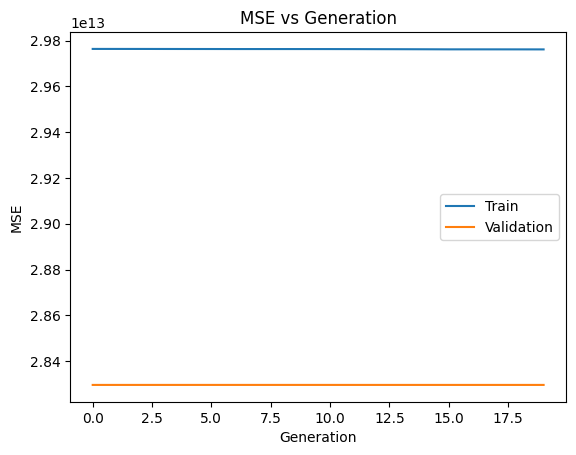

Train MSE: [2.97614596e+13], Validation MSE: [2.82961009e+13]


<Figure size 1400x800 with 0 Axes>

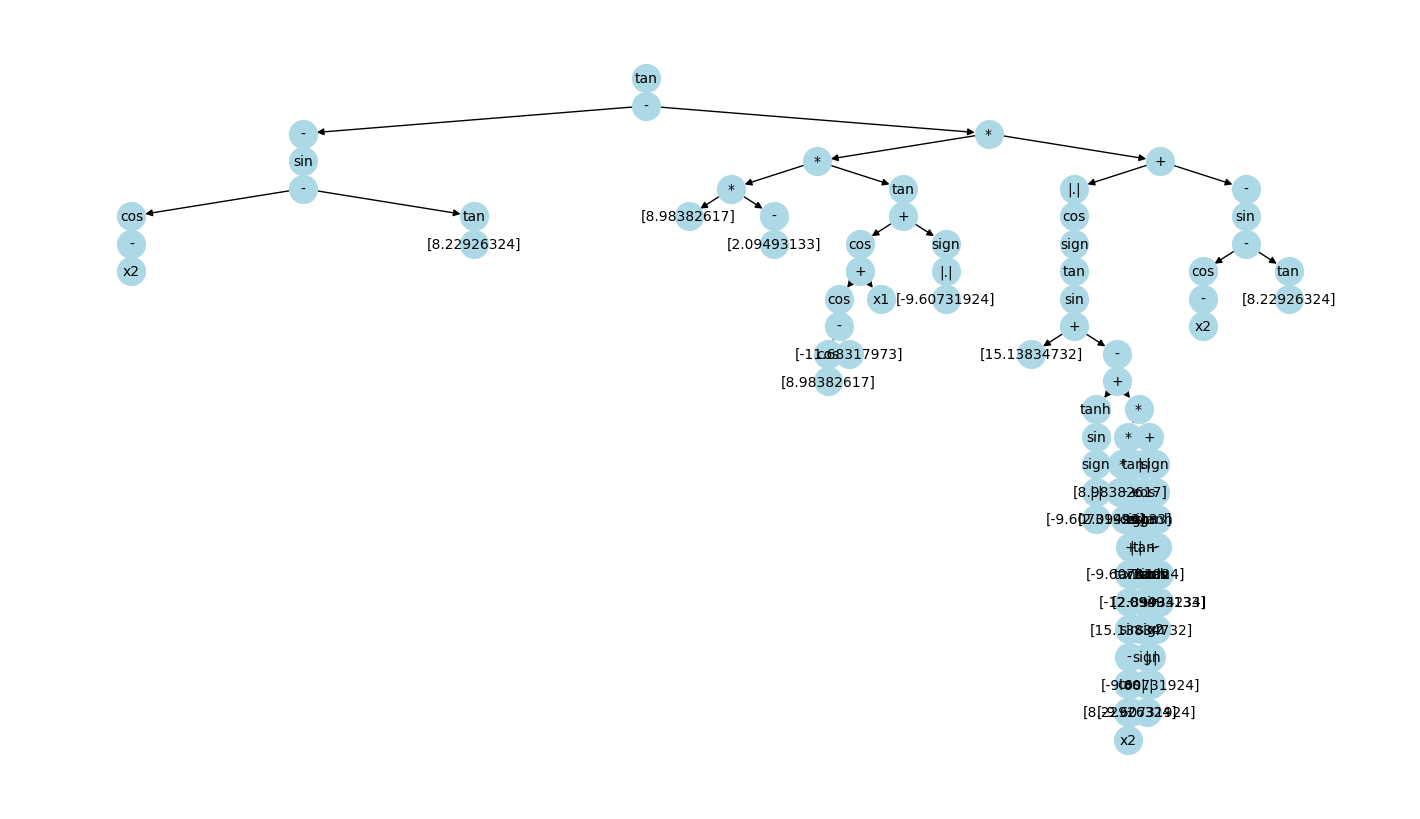

In [71]:
import matplotlib.pyplot as plt

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
champion = evolutionary_solve(population)

plt.figure(figsize=(14,8))
champion.genome.draw()
mse_val = Tree.mse(champion.genome, x_val, y_val)
print(f"Train MSE: {champion.mse}, Validation MSE: {mse_val}")

In [72]:
for operator in operators:
    print(operator.symbol, operator.function, operator.fanin)
    args = tuple(np.random.random() for _ in range(operator.fanin))
    operator.function(*args)

+ <built-in function add> 2
- <built-in function sub> 2
* <built-in function mul> 2
|.| <built-in function abs> 1
- <built-in function neg> 1
sign <ufunc 'sign'> 1
cbrt <ufunc 'cbrt'> 1
sin <ufunc 'sin'> 1
cos <ufunc 'cos'> 1
tan <ufunc 'tan'> 1
tanh <ufunc 'tanh'> 1


In [73]:
np.sin(np.tan(1.504))

np.float64(0.6884517773706234)

In [74]:
import inspect

numpy_operators = [getattr(np, obj) for obj in dir(np) if isinstance(getattr(np, obj), np.ufunc)]
print(numpy_operators)
[len(inspect.signature(op).parameters) for op in numpy_operators]
import operator
len(inspect.signature(operator.abs).parameters)


[<ufunc 'absolute'>, <ufunc 'absolute'>, <ufunc 'arccos'>, <ufunc 'arccosh'>, <ufunc 'add'>, <ufunc 'arccos'>, <ufunc 'arccosh'>, <ufunc 'arcsin'>, <ufunc 'arcsinh'>, <ufunc 'arctan'>, <ufunc 'arctan2'>, <ufunc 'arctanh'>, <ufunc 'arcsin'>, <ufunc 'arcsinh'>, <ufunc 'arctan'>, <ufunc 'arctan2'>, <ufunc 'arctanh'>, <ufunc 'bitwise_and'>, <ufunc 'bitwise_count'>, <ufunc 'invert'>, <ufunc 'left_shift'>, <ufunc 'invert'>, <ufunc 'bitwise_or'>, <ufunc 'right_shift'>, <ufunc 'bitwise_xor'>, <ufunc 'cbrt'>, <ufunc 'ceil'>, <ufunc 'conjugate'>, <ufunc 'conjugate'>, <ufunc 'copysign'>, <ufunc 'cos'>, <ufunc 'cosh'>, <ufunc 'deg2rad'>, <ufunc 'degrees'>, <ufunc 'divide'>, <ufunc 'divmod'>, <ufunc 'equal'>, <ufunc 'exp'>, <ufunc 'exp2'>, <ufunc 'expm1'>, <ufunc 'fabs'>, <ufunc 'float_power'>, <ufunc 'floor'>, <ufunc 'floor_divide'>, <ufunc 'fmax'>, <ufunc 'fmin'>, <ufunc 'fmod'>, <ufunc 'frexp'>, <ufunc 'gcd'>, <ufunc 'greater'>, <ufunc 'greater_equal'>, <ufunc 'heaviside'>, <ufunc 'hypot'>, <ufu

1